In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import gdown

# totalVI

## Load the dataset

In [2]:
gdown.download(
    'https://drive.google.com/uc?id=1wA3VBUnYEW2qHPk9WijNTKjV9KriWe8y',
    'kotliarov2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1wA3VBUnYEW2qHPk9WijNTKjV9KriWe8y
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/kotliarov2020-expressions.h5ad
137MB [00:01, 108MB/s]  


'kotliarov2020-expressions.h5ad'

In [3]:
scrna = sc.read_h5ad('kotliarov2020-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 52117 × 3999
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=112mdDX76LZRL33tBLYhfYRRXOUrLUhw-',
    'kotliarov2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=112mdDX76LZRL33tBLYhfYRRXOUrLUhw-
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/kotliarov2020-proteins.h5ad
143MB [00:01, 75.3MB/s] 


'kotliarov2020-proteins.h5ad'

In [5]:
cite = sc.read_h5ad('kotliarov2020-proteins.h5ad')
cite

AnnData object with n_obs × n_vars = 52117 × 87
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [6]:
# scvi needs one adata, so we merge rna and cite
adata = scrna
adata.X = scrna.layers['count']
adata.obsm['proteins'] = cite.layers['count']

In [7]:
scvi.data.setup_anndata(adata, batch_key='batch', labels_key='cell_type', protein_expression_obsm_key='proteins')

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['proteins']                                
INFO     Generating sequential protein names                                                 
INFO     Successfully registered anndata object containing 52117 cells, 3999 genes, 2        
         batches, 10 labels, and 87 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [8]:
vae = scvi.model.TOTALVI(
    adata,
    latent_distribution="normal",
    n_layers_decoder=2
)

In [9]:
vae.train(n_epochs=100)

INFO     KL warmup phase may exceed overall training phase.If your applications rely on      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 39087.75 iterations                                                   


Output()

INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  679 s. / 100 epochs                                                 


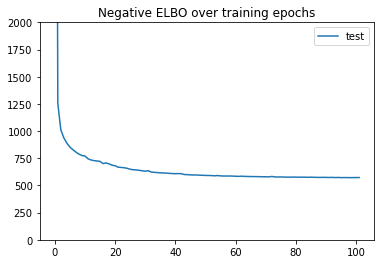

In [10]:
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(0, 2000)
plt.legend()

In [11]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

In [12]:
z = sc.AnnData(adata.obsm["X_totalVI"])
z.obs = adata.obs

In [13]:
z.write('../data/integrated/totalvi/kotliarov-totalvi.h5ad')

In [14]:
!rm 'kotliarov2020-expressions.h5ad'
!rm 'kotliarov2020-proteins.h5ad'

## Visualize results

In [14]:
x=2

In [15]:
z = sc.read('../data/integrated/totalvi/kotliarov-totalvi.h5ad')
z

AnnData object with n_obs × n_vars = 52117 × 20
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'

In [16]:
sc.pp.neighbors(z)
sc.tl.umap(z)

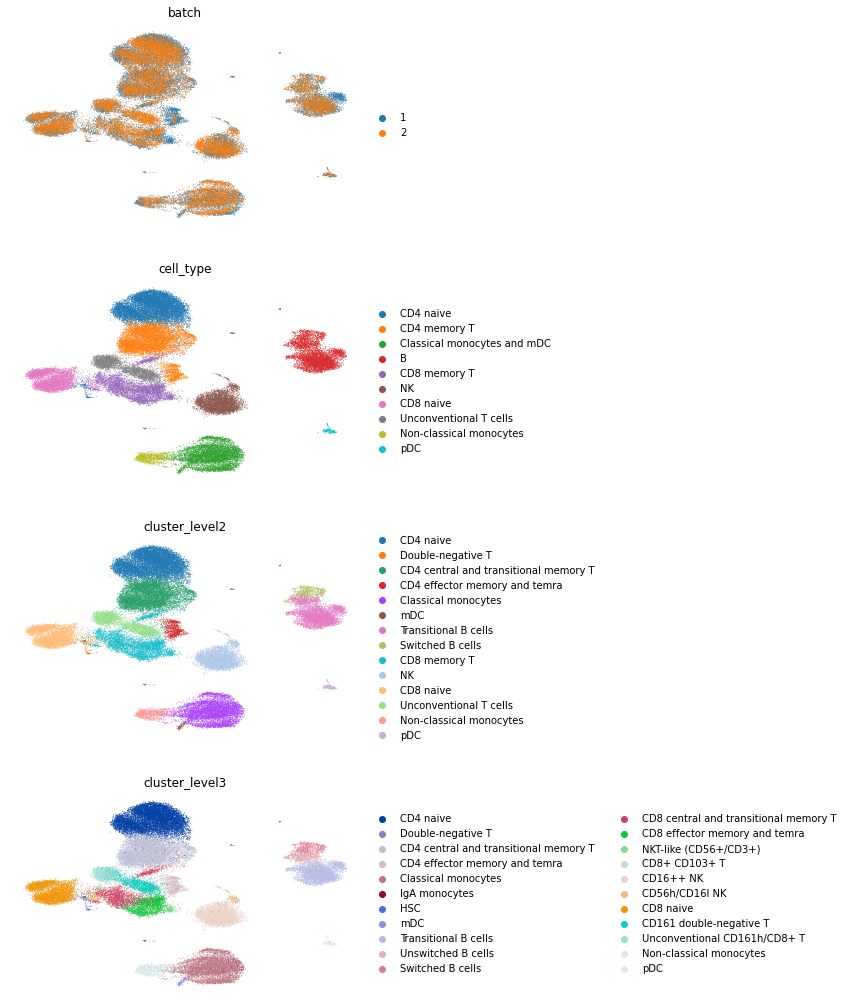

In [17]:
sc.pl.umap(z, color=['batch', 'cell_type', 'cluster_level2', 'cluster_level3'], ncols=1, frameon=False)